In [118]:
# IMPORT LIBRARIES

import math
import random
import itertools
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import seaborn as sns
from tqdm import tqdm
from statistics import mean, stdev

# TASK 1

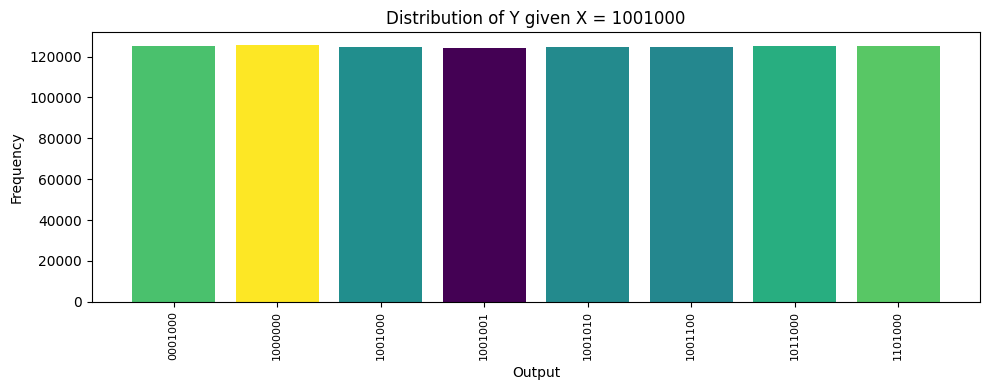

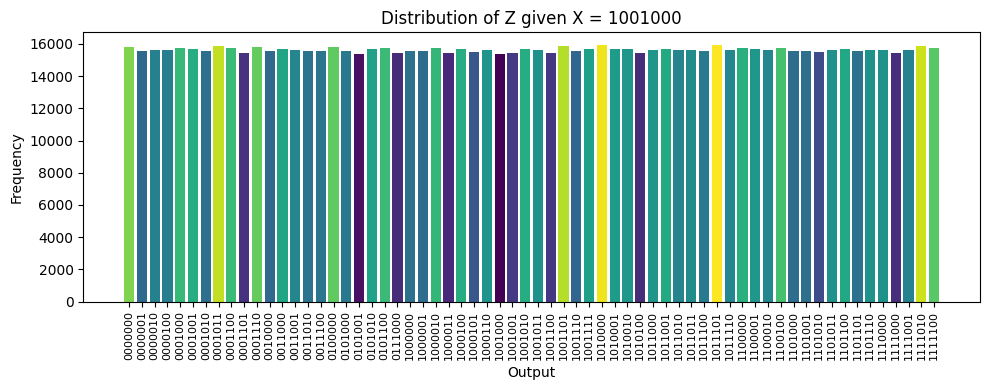

In [119]:
def hamming_distance(a, b):
    """Calculate the Hamming distance between two binary strings.""" 
    return sum(x != y for x, y in zip(a, b))

def generate_error_set(x, max_errors):
    """Generate all binary vectors with up to max_errors bit flips from x."""
    n = len(x)
    neighbors = set()
    x_int = int(x, 2)

    # Nessun errore
    neighbors.add(x_int)

    for num_errors in range(1, max_errors + 1):
        for bit_positions in itertools.combinations(range(n), num_errors):
            error_mask = sum(1 << pos for pos in bit_positions)
            neighbors.add(x_int ^ error_mask)

    return [format(v, f"0{n}b") for v in neighbors]

def wiretap_channel(x):
    """
    Simulate a wiretap channel:
    - y: legitimate receiver's output (max 1 error)
    - z: eavesdropper's output (max 3 errors)
    """
    Ty = generate_error_set(x, 1)
    Tz = generate_error_set(x, 3)
    y = random.choice(Ty)
    z = random.choice(Tz)
    return y, z

def run_experiment(x, num_samples=10000):
    """Run multiple simulations of the wiretap channel."""
    y_samples = []
    z_samples = []

    for _ in range(num_samples):
        y, z = wiretap_channel(x)
        y_samples.append(y)
        z_samples.append(z)

    return y_samples, z_samples

def plot_distribution(samples, title):
    """Plot the distribution of channel outputs."""
    counter = Counter(samples)
    labels, counts = zip(*sorted(counter.items()))
    plt.figure(figsize=(10, 4))
    plt.bar(labels, counts, color=plt.get_cmap("viridis")(rescale(counts)))
    plt.xticks(rotation=90, fontsize=8)
    plt.title(title)
    plt.xlabel("Output")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

x_input = "1001000"
y_samples, z_samples = run_experiment(x_input, 1000000)
plot_distribution(y_samples, "Distribution of Y given X = 1001000")
plot_distribution(z_samples, "Distribution of Z given X = 1001000")


As observed in the graphs, every possible output of Y and Z appears with the same frequency, indicating that the outputs of the two channels are uniformly distributed. This suggests that the error model operates in a way that ensures all possible outcomes occur with equal likelihood, reinforcing the assumption of statistical fairness in error propagation.

In [120]:
def compute_tvd(y_samples, z_samples):
    """Compute Total Variation Distance to check independence."""
    joint_counter = Counter(zip(y_samples, z_samples))
    y_counter = Counter(y_samples)
    z_counter = Counter(z_samples)
    n = len(y_samples)

    tvd = 0
    for (y, z), joint_freq in joint_counter.items():
        py = y_counter[y] / n
        pz = z_counter[z] / n
        p_joint = joint_freq / n
        p_product = py * pz
        tvd += abs(p_joint - p_product)
    
    tvd *= 0.5
    return tvd

tvd_value = compute_tvd(y_samples, z_samples)
print(f"Total Variation Distance: {tvd_value:.5f}")


Total Variation Distance: 0.00862


A Total Variation Distance (TVD) close to zero suggests that the outputs are nearly independent, meaning there is little to no dependence between Y and Z.

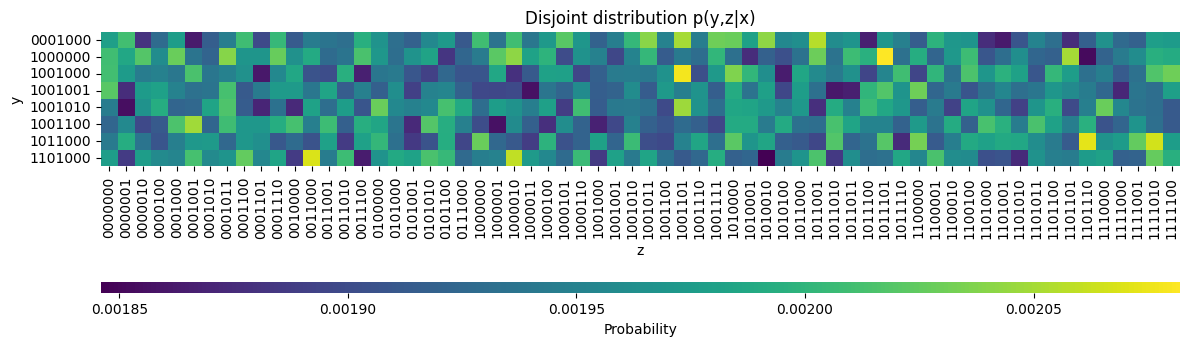

In [121]:
def plot_joint_heatmap(y_samples, z_samples, title="Disjoint distribution p(y,z|x)"):
    """Plot heatmap of joint probability distribution."""
    y_vals = sorted(set(y_samples))
    z_vals = sorted(set(z_samples))

    y_idx = {val: i for i, val in enumerate(y_vals)}
    z_idx = {val: i for i, val in enumerate(z_vals)}

    # Matrice vuota
    joint_matrix = np.zeros((len(y_vals), len(z_vals)))

    # Riempi la matrice con le frequenze
    for y, z in zip(y_samples, z_samples):
        joint_matrix[y_idx[y], z_idx[z]] += 1

    # Normalizza (frequenze relative)
    joint_matrix /= len(y_samples)

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        joint_matrix, xticklabels=z_vals, yticklabels=y_vals, cmap="viridis",
        cbar_kws={'label': 'Probability', "orientation": "horizontal", "aspect": 100},
        square=True
    )
    plt.title(title)
    plt.xlabel("z")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

plot_joint_heatmap(y_samples, z_samples)

The heatmap does not reveal any significant correlation patterns between Y and Z, indicating that the channels generate conditionally independent outputs.

# TASK 2

In [122]:
# List of the 16 Hamming (7,4) codewords
HAMMING_CODEWORDS = [
    "0000000", "1000110", "0100101", "0010011",
    "0001111", "1100011", "1010101", "1001001",
    "0110110", "0101010", "0011100", "1110000",
    "1101100", "1011010", "0111001", "1111111"
]

def complement(bits):
    """Flip each bit in a binary string."""
    return ''.join('1' if b == '0' else '0' for b in bits)

def get_bin_for_message(u):
    """
    Find Hamming codewords corresponding to a given 3-bit message u.
    """
    assert len(u) == 3 and set(u) <= {'0', '1'} # Ensure input validity

    bin_prefix = "0" + u   # Construct a 4-bit prefix [0, u]
    
    for cw in HAMMING_CODEWORDS:
        if cw.startswith(bin_prefix):
            comp = complement(cw)
            if comp in HAMMING_CODEWORDS:
                return [cw, comp]
            else:
                return [cw]  # Fallback in case of missing complement
    raise ValueError(f"No codeword with prefix [0, {u}] found.")

def random_binning_encoder(u):
    """
    Encode a 3-bit message u using random binning.
    """
    bin_codewords = get_bin_for_message(u)
    return random.choice(bin_codewords)

# Test encoder
for u in ["000", "001", "010", "011", "100", "101", "110", "111"]:
    bin_set = get_bin_for_message(u)
    print(f"Message {u} → bin: {bin_set}")


Message 000 → bin: ['0000000', '1111111']
Message 001 → bin: ['0001111', '1110000']
Message 010 → bin: ['0010011', '1101100']
Message 011 → bin: ['0011100', '1100011']
Message 100 → bin: ['0100101', '1011010']
Message 101 → bin: ['0101010', '1010101']
Message 110 → bin: ['0110110', '1001001']
Message 111 → bin: ['0111001', '1000110']


# TASK 3

In [123]:
def hamming_distance(a, b):
    """Calculate the Hamming distance between two binary strings."""
    return sum(x != y for x, y in zip(a, b))

def decode_message_from_codeword(x_hat):
    """
    Extract the message û from a codeword.
    If the first bit is 0: take [x₂ x₃ x₄].
    If the first bit is 1: take the complement of [x₂ x₃ x₄].
    """
    info_bits = x_hat[1:4]
    if x_hat[0] == '0':
        return info_bits
    else:
        return complement(info_bits)

def legit_decoder(y):
    """
    Implement the decoder:
    - Find the closest codeword x̂ to y (minimum Hamming distance).
    - Extract û from the information bits.
    """
    x_hat = min(HAMMING_CODEWORDS, key=lambda cw: hamming_distance(y, cw))
    return decode_message_from_codeword(x_hat)


In [124]:
def test_encoder_decoder():
    """Test encoder-decoder process without noise."""
    correct = 0
    trials = 1000
    for _ in tqdm(range(trials)):
        u = format(random.randint(0, 7), "03b")
        x = random_binning_encoder(u)
        y = x  # No noise introduced
        u_hat = legit_decoder(y)
        if u_hat == u:
            correct += 1
        print("Starting message: ", u)
        print("Crypted messagge: ", y)
        print("Decryption:       ", u_hat , '\n')
    print(f"Decoder accuracy (without errors): {correct}/{trials}")
    
test_encoder_decoder()


100%|██████████| 1000/1000 [00:00<00:00, 15719.19it/s]

Starting message:  000
Crypted messagge:  1111111
Decryption:        000 

Starting message:  111
Crypted messagge:  0111001
Decryption:        111 

Starting message:  000
Crypted messagge:  0000000
Decryption:        000 

Starting message:  110
Crypted messagge:  1001001
Decryption:        110 

Starting message:  101
Crypted messagge:  1010101
Decryption:        101 

Starting message:  011
Crypted messagge:  1100011
Decryption:        011 

Starting message:  001
Crypted messagge:  1110000
Decryption:        001 

Starting message:  000
Crypted messagge:  0000000
Decryption:        000 

Starting message:  010
Crypted messagge:  1101100
Decryption:        010 

Starting message:  001
Crypted messagge:  1110000
Decryption:        001 

Starting message:  010
Crypted messagge:  0010011
Decryption:        010 

Starting message:  111
Crypted messagge:  1000110
Decryption:        111 

Starting message:  011
Crypted messagge:  1100011
Decryption:        011 

Starting message:  010
Cr

In [125]:
def apply_legitimate_channel(x):
    """
    Simulate the legitimate channel, introducing at most 1 error.
    """
    error_patterns = generate_error_set(x, 1)
    return random.choice(error_patterns)

def test_encoder_channel_decoder():
    """Test encoder-decoder process with a noisy channel (max 1 error)."""
    correct = 0
    trials = 1000
    for _ in tqdm(range(trials)):
        u = format(random.randint(0, 7), "03b")
        x = random_binning_encoder(u)
        y = apply_legitimate_channel(x)  # 0 or 1 errors
        u_hat = legit_decoder(y)
        if u_hat == u:
            correct += 1
        print("Starting message:               ", u)
        print("Crypted messagge:               ", x)
        print("Crypted messagge after channel: ", y)
        print("Decryption:                     ", u_hat , '\n')
    print(f"Decoder accuracy with channel (max 1 error): {correct}/{trials}")

test_encoder_channel_decoder()


100%|██████████| 1000/1000 [00:00<00:00, 10175.83it/s]

Starting message:                010
Crypted messagge:                0010011
Crypted messagge after channel:  0010010
Decryption:                      010 

Starting message:                101
Crypted messagge:                0101010
Crypted messagge after channel:  0101110
Decryption:                      101 

Starting message:                101
Crypted messagge:                0101010
Crypted messagge after channel:  0101000
Decryption:                      101 

Starting message:                101
Crypted messagge:                0101010
Crypted messagge after channel:  0100010
Decryption:                      101 

Starting message:                101
Crypted messagge:                0101010
Crypted messagge after channel:  0101000
Decryption:                      101 

Starting message:                010
Crypted messagge:                0010011
Crypted messagge after channel:  0000011
Decryption:                      010 

Starting message:                100
Crypted messagg

# TASK 4

In [151]:
def apply_eavesdropper_channel(x):
    """
    Simula il canale di Eve che introduce fino a 3 errori.
    """
    error_patterns = generate_error_set(x, 3)
    return random.choice(error_patterns)

def simulate_encoder_eavesdropper_chain(n_samples_per_u=2000):
    u_values = [format(i, "03b") for i in range(8)]
    z_given_u = defaultdict(list)

    for u in u_values:
        for _ in range(n_samples_per_u):
            x = random_binning_encoder(u)
            z = apply_eavesdropper_channel(x)
            z_given_u[u].append(z)
    
    return z_given_u

In [152]:
def compute_empirical_distributions(z_given_u):
    """
    Computes empirical distributions: p̂(u), p̂(z), and joint distribution p̂(u, z).
    """
    joint_counts = Counter()
    u_counts = Counter()
    z_counts = Counter()
    total = 0

    for u, z_list in z_given_u.items():
        for z in z_list:
            joint_counts[(u, z)] += 1
            u_counts[u] += 1
            z_counts[z] += 1
            total += 1

    # Computes p̂(u), p̂(z), p̂(u,z)
    p_u = {u: u_counts[u] / total for u in u_counts}
    p_z = {z: z_counts[z] / total for z in z_counts}
    p_joint = {(u, z): joint_counts[(u, z)] / total for (u, z) in joint_counts}

    # Computes Î(u; z)
    I = 0
    for (u, z), p_uz in p_joint.items():
        p_u_val = p_u[u]
        p_z_val = p_z[z]
        I += p_uz * math.log2(p_uz / (p_u_val * p_z_val))

    return p_u, p_z, p_joint, I

def compute_conditional_pmd(joint_counts, u_counts):
    """
    Computes the conditional PMD p̂(z|u) for all values of u.
    """
    conditional_pmd = {}
    for (u, z), joint_count in joint_counts.items():
        conditional_pmd[(u, z)] = joint_count / u_counts[u]
    return conditional_pmd

def compute_entropy(p_u):
    """
    Computes the entropy H(u) from the marginal distribution p̂(u).
    """
    return -sum(p * math.log2(p) for p in p_u.values())


def plot_conditional_pmd(conditional_pmd, d_values, z_values, max_z_values=30):
    """
    Plots the conditional PMD p̂(z|u) for all d values with truncated z values.
    """
    # Truncate z_values if too many
    if len(z_values) > max_z_values:
        z_values = z_values[:max_z_values] # Truncated for clarity

    # Construct a matrix for heatmap
    matrix = [[conditional_pmd.get((d, z), 0) for z in z_values] for d in d_values]
    
    # Plot
    plt.figure(figsize=(12, 6))  # Adjust figure size
    sns.heatmap(matrix, annot=False, fmt=".3f", xticklabels=z_values, yticklabels=d_values, cmap="coolwarm")
    plt.xlabel("z values")
    plt.ylabel("d values")
    plt.title("Conditional PMD p̂(z|d)")
    plt.tight_layout()
    plt.show()


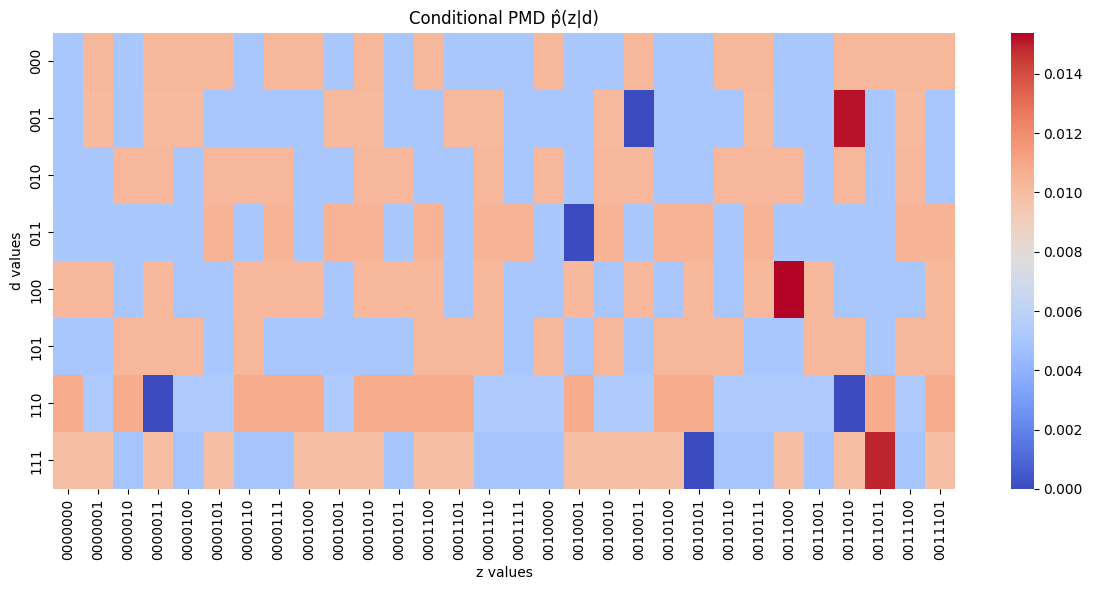

Mutual information Î(u; z) = 0.040128 bits
Entropy H(u) = 3.000000 bits


In [153]:
z_given_u = simulate_encoder_eavesdropper_chain()
p_u, p_z, p_joint, I_hat = compute_empirical_distributions(z_given_u)
 
# Compute conditional PMDs
joint_counts = Counter({(u, z): int(p * 2000) for (u, z), p in p_joint.items()})  # Approx. joint counts
u_counts = Counter({u: sum(joint_counts[(u, z)] for z in p_z) for u in p_u})
conditional_pmd = compute_conditional_pmd(joint_counts, u_counts)

# Plot conditional PMDs
z_values = sorted(set(z for _, z in joint_counts))
d_values = sorted(p_u.keys())
plot_conditional_pmd(conditional_pmd, d_values, z_values)

# Compute H(u)
H_u = compute_entropy(p_u)

print(f"Mutual information Î(u; z) = {I_hat:.6f} bits")
print(f"Entropy H(u) = {H_u:.6f} bits")


# TASK 5

Wiretap BSC channel

In [129]:
def bsc_channel(x, error_prob):
    """
    Simulate a BSC channel: Each bit has an error probability of error_prob to be flipped.
    """
    return ''.join(('0' if b == '1' else '1') if random.random() < error_prob else b for b in x)



Test the BSC with encoding and decoding

In [130]:
def test_bsc_encoder_decoder(epsilon=0.05, delta=0.15, n_samples=1000):
    """
    Simulate transmission over a BSC with error probabilities ε and δ for Bob and Eve, respectively.
    """
    errors_bob = 0
    u_values = [format(i, "03b") for i in range(8)]

    for _ in range(n_samples):
        u = random.choice(u_values)
        x = random_binning_encoder(u)

        # Bob: x → y
        y = bsc_channel(x, epsilon)
        u_hat = legit_decoder(y)

        if u_hat != u:
            errors_bob += 1

    error_rate = errors_bob / n_samples
    print(f"Bob's error on {n_samples} samples: {error_rate:.3f}")

In [131]:
test_bsc_encoder_decoder(epsilon=0.08, delta=0.20, n_samples=5000)

Bob's error on 5000 samples: 0.103


# TASK 6

We implemented a wiretap channel with independent bit-flip errors (a BSC), using error probability ε for Bob and δ for Eve.
By connecting our random-binning encoder (Task 2) and decoder (Task 3), we observed that perfect reliability for Bob is lost whenever ε becomes large enough: a single-error-correcting code (e.g. Hamming code) no longer suffices.

In [132]:
def simulate_metrics(epsilon, delta, n_samples=10000):
    """
    Simulate both Bob's and Eve's channels, and compute reliability, secrecy, TVD, and distinguishability.
    """
    u_vals = [format(i, '03b') for i in range(8)]
    bob_errors = 0
    joint_counts = Counter()
    u_counts = Counter()
    z_counts = Counter()
    total = n_samples

    for _ in range(n_samples):
        u = random.choice(u_vals)
        x = random_binning_encoder(u)

        # Bob
        y = bsc_channel(x, epsilon)
        u_hat = legit_decoder(y)
        if u_hat != u:
            bob_errors += 1

        # Eve
        z = bsc_channel(x, delta)

        joint_counts[(u, z)] += 1
        u_counts[u] += 1
        z_counts[z] += 1

    # Empirical probabilities
    p_u = {u: u_counts[u] / total for u in u_counts}
    p_z = {z: z_counts[z] / total for z in z_counts}
    p_uz = {(u, z): joint_counts[(u, z)] / total for (u, z) in joint_counts}

    # Bob's error rate
    error_rate = bob_errors / total

    # Mutual information I(u; z) between u and z (Eve's channel)
    I = 0
    for (u, z), puz in p_uz.items():
        pu = p_u[u]
        pz = p_z[z]
        I += puz * math.log2(puz / (pu * pz))

    # Total Variation Distance (TVD)
    tvd = sum(abs(puz - p_u[u]*p_z[z]) for (u, z), puz in p_uz.items()) * 0.5

    # Empirical distinguishability
    # D(M, M⋆) = 0.5 * sum |p(u,z) - p(u)*p(z)|
    d_empirical = tvd

    # Upper bound: Pinsker inequality: D ≤ sqrt(0.5 * I)
    d_upper_bound = math.sqrt(0.5 * I)

    return error_rate, I, tvd, d_empirical, d_upper_bound


In [133]:
eps_vals = np.linspace(0, 0.2, 5)
delta_vals = np.linspace(0, 0.4, 5)

results = []

for eps in eps_vals:
    for delt in delta_vals:
        err, info, tvd, d_real, d_bound = simulate_metrics(eps, delt)
        results.append({
            "ε": eps,
            "δ": delt,
            "ErrorRate": err,
            "I(u;z)": info,
            "TVD": tvd,
            "D_real": d_real,
            "D_bound": d_bound
        })
        print(f"ε={eps:.2f}, δ={delt:.2f} | Err={err:.3f}, I={info:.3f}, TVD={tvd:.3f}, D={d_real:.3f}, Bound={d_bound:.3f}")


ε=0.00, δ=0.00 | Err=0.000, I=3.000, TVD=0.437, D=0.437, Bound=1.225
ε=0.00, δ=0.10 | Err=0.000, I=2.259, TVD=0.522, D=0.522, Bound=1.063
ε=0.00, δ=0.20 | Err=0.000, I=1.100, TVD=0.472, D=0.472, Bound=0.742
ε=0.00, δ=0.30 | Err=0.000, I=0.350, TVD=0.267, D=0.267, Bound=0.418
ε=0.00, δ=0.40 | Err=0.000, I=0.087, TVD=0.136, D=0.136, Bound=0.208
ε=0.05, δ=0.00 | Err=0.046, I=3.000, TVD=0.437, D=0.437, Bound=1.225
ε=0.05, δ=0.10 | Err=0.045, I=2.248, TVD=0.481, D=0.481, Bound=1.060
ε=0.05, δ=0.20 | Err=0.043, I=1.108, TVD=0.465, D=0.465, Bound=0.744
ε=0.05, δ=0.30 | Err=0.046, I=0.343, TVD=0.265, D=0.265, Bound=0.414
ε=0.05, δ=0.40 | Err=0.042, I=0.088, TVD=0.137, D=0.137, Bound=0.209
ε=0.10, δ=0.00 | Err=0.149, I=2.999, TVD=0.437, D=0.437, Bound=1.225
ε=0.10, δ=0.10 | Err=0.154, I=2.257, TVD=0.509, D=0.509, Bound=1.062
ε=0.10, δ=0.20 | Err=0.157, I=1.048, TVD=0.458, D=0.458, Bound=0.724
ε=0.10, δ=0.30 | Err=0.151, I=0.333, TVD=0.260, D=0.260, Bound=0.408
ε=0.10, δ=0.40 | Err=0.152, I=0.08

For each (𝜀,𝛿) pair, we ran 10,000 random transmissions and computed:

- Bob’s decoding error rate, which increases as ε grows.

- The mutual information I(u;z), which increases as Eve’s channel quality improves.

- The total variation distance between the joint distribution and the product of the marginals.

- The empirical distinguishability D(M,M∗), compared against its theoretical upper bound √0.5I(u;z)
​
 .

In [134]:
data_by_eps = defaultdict(list)
data_by_delta = defaultdict(list)

for res in results:
    eps = res["ε"]
    delt = res["δ"]
    data_by_eps[eps].append(res)
    data_by_delta[delt].append(res)

In [135]:
def plot_bob_error_by_epsilon(fixed_delta=0.2):
    """
    Plot Bob's error rate as a function of ε (with fixed δ).
    """
    eps_list = sorted(data_by_eps.keys())
    errors = [
        next(r for r in data_by_eps[eps] if abs(r["δ"] - fixed_delta) < 1e-6)["ErrorRate"]
        for eps in eps_list
    ]
    plt.plot(eps_list, errors, marker='o', label=f"δ = {fixed_delta}")
    plt.xlabel("ε (Bob's BSC error rate)")
    plt.ylabel("P[u ≠ û] (error rate)")
    plt.title("Bob's error vs. ε (δ fixed)")
    plt.grid(True)
    plt.legend()
    plt.show()


In [136]:
def plot_mutual_info_by_delta(fixed_epsilon=0.05):
    """
    Plot mutual information I(u; z) as a function of δ (with fixed ε).
    """
    delta_list = sorted(data_by_delta.keys())
    infos = [
        next(r for r in data_by_delta[d] if abs(r["ε"] - fixed_epsilon) < 1e-6)["I(u;z)"]
        for d in delta_list
    ]
    plt.plot(delta_list, infos, marker='s', color='darkblue', label=f"ε = {fixed_epsilon}")
    plt.xlabel("δ (Eve's BSC error rate)")
    plt.ylabel("Mutual information I(u; z)")
    plt.title("I(u; z) vs. δ (ε fixed)")
    plt.grid(True)
    plt.legend()
    plt.show()


In [137]:
def plot_distinguishability_vs_bound(fixed_epsilon=0.05):
    """
    Plot the empirical distinguishability and its upper bound as a function of δ (with fixed ε).
    """
    delta_list = sorted(data_by_delta.keys())
    d_real = [
        next(r for r in data_by_delta[d] if abs(r["ε"] - fixed_epsilon) < 1e-6)["D_real"]
        for d in delta_list
    ]
    d_bound = [
        next(r for r in data_by_delta[d] if abs(r["ε"] - fixed_epsilon) < 1e-6)["D_bound"]
        for d in delta_list
    ]
    plt.plot(delta_list, d_real, marker='o', label="Empirical Distinguishability D(M, M*)")
    plt.plot(delta_list, d_bound, marker='x', linestyle='--', label="Upper Bound √(0.5·I(u;z))")
    plt.xlabel("δ (Eve's BSC error rate)")
    plt.ylabel("Distinguishability")
    plt.title("Empirical Distinguishability vs. Upper Bound")
    plt.grid(True)
    plt.legend()
    plt.show()


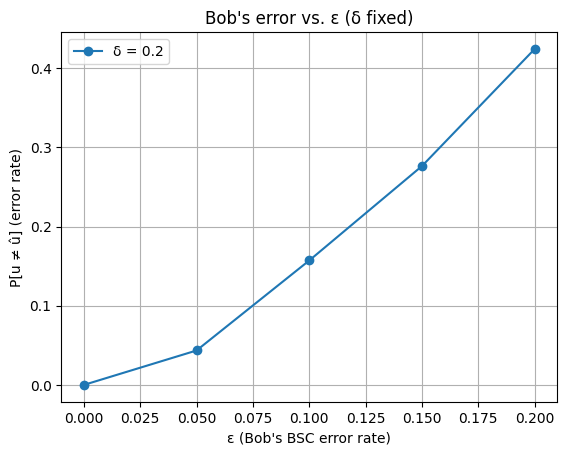

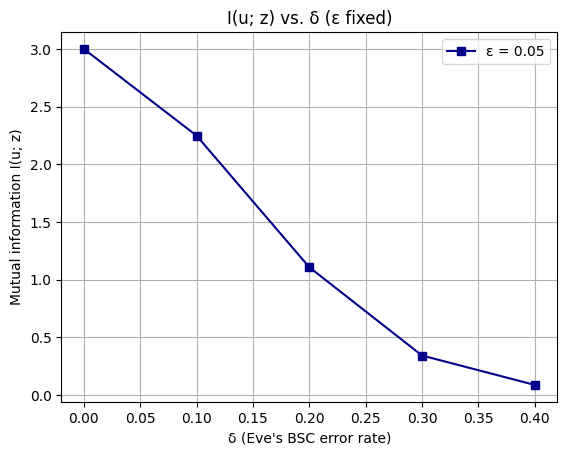

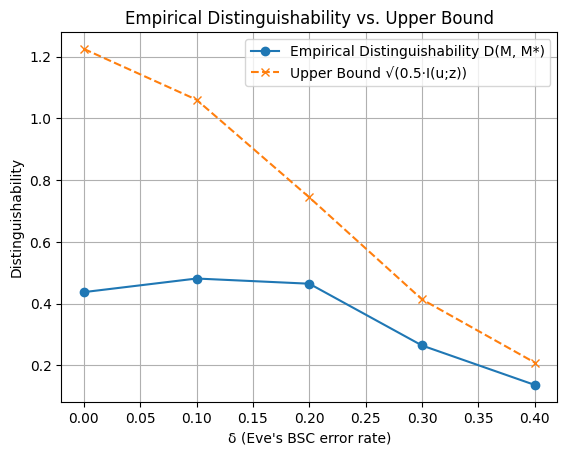

In [138]:
plot_bob_error_by_epsilon(fixed_delta=0.2)
plot_mutual_info_by_delta(fixed_epsilon=0.05)
plot_distinguishability_vs_bound(fixed_epsilon=0.05)

## TASK 7

In [139]:
def pam_modulate(bits, levels=2):
    """
    Map binary bits to PAM symbols in {-1, +1} using 1-bit mapping.
    """
    return np.array([1 - 2 * int(b) for b in bits])

def pam_demodulate(symbols):
    """
    Demodulate PAM symbols back to bits using zero threshold.
    """
    return ''.join(['0' if s > 0 else '1' for s in symbols])


In [140]:
def awgn_channel(signal, snr_db):
    """
    Add white Gaussian noise to signal for a given SNR in dB.
    """
    snr_linear = 10 ** (snr_db / 10)
    power_signal = np.mean(signal**2)
    noise_variance = power_signal / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_variance), size=signal.shape)
    return signal + noise


Complete encoder chain → mod → AWGN → demod → decoder

In [141]:
def simulate_awgn_transmission(snr_bob=5, snr_eve=0, n_samples=1000):
    """
    Transmit random-binned codewords over AWGN to Bob and Eve, return their BERs.
    """
    errors_bob = 0
    errors_eve = 0
    u_values = [format(i, "03b") for i in range(8)]

    for _ in range(n_samples):
        u = random.choice(u_values)
        x = random_binning_encoder(u)
        s = pam_modulate(x)

        # Bob
        y = awgn_channel(s, snr_bob)
        x_bob = pam_demodulate(y)
        u_bob = legit_decoder(x_bob)
        if u_bob != u:
            errors_bob += 1

        # Eve
        z = awgn_channel(s, snr_eve)
        x_eve = pam_demodulate(z)
        u_eve = legit_decoder(x_eve)  # or "raw bits" if you want to simulate only the demulation
        if u_eve != u:
            errors_eve += 1

    return errors_bob / n_samples, errors_eve / n_samples


In [142]:
for snr_bob in [0, 5, 10, 15]:
    for snr_eve in [0, 5, 10]:
        err_b, err_e = simulate_awgn_transmission(snr_bob, snr_eve)
        print(f"SNR Bob={snr_bob} dB, Eve={snr_eve} dB → Bob err={err_b:.3f}, Eve err={err_e:.3f}")

SNR Bob=0 dB, Eve=0 dB → Bob err=0.305, Eve err=0.301
SNR Bob=0 dB, Eve=5 dB → Bob err=0.319, Eve err=0.026
SNR Bob=0 dB, Eve=10 dB → Bob err=0.311, Eve err=0.000
SNR Bob=5 dB, Eve=0 dB → Bob err=0.027, Eve err=0.269
SNR Bob=5 dB, Eve=5 dB → Bob err=0.029, Eve err=0.033
SNR Bob=5 dB, Eve=10 dB → Bob err=0.027, Eve err=0.000
SNR Bob=10 dB, Eve=0 dB → Bob err=0.000, Eve err=0.308
SNR Bob=10 dB, Eve=5 dB → Bob err=0.000, Eve err=0.039
SNR Bob=10 dB, Eve=10 dB → Bob err=0.000, Eve err=0.000
SNR Bob=15 dB, Eve=0 dB → Bob err=0.000, Eve err=0.297
SNR Bob=15 dB, Eve=5 dB → Bob err=0.000, Eve err=0.037
SNR Bob=15 dB, Eve=10 dB → Bob err=0.000, Eve err=0.000


We have implemented an analog transmission over an AWGN channel using binary PAM modulation.
The transmitted signal is corrupted by Gaussian noise whose variance is set by the SNR, which can differ for Bob and Eve.
The results confirm that both reliability and secrecy depend critically on SNR:

- Bob makes errors if his SNR is too low.

- Eve can reconstruct the message if her SNR is too high.

In this setup, perfect secrecy is not guaranteed by default, but it can be achieved by ensuring Bob has a sufficient SNR advantage.

# TASK 8

Complete encoder simulation → mod → AWGN → demod → decoder


In [143]:
def simulate_awgn_metrics(snr_bob=10, snr_eve=0, n_samples=10000):
    """
    Compute BER, mutual info, TVD, and secrecy capacity metrics for AWGN wiretap.
    """
    u_vals = [format(i, '03b') for i in range(8)]
    errors_bob = 0
    errors_eve = 0

    joint_counts = Counter()
    u_counts = Counter()
    z_counts = Counter()

    for _ in range(n_samples):
        u = random.choice(u_vals)
        x = random_binning_encoder(u)
        s = pam_modulate(x)

        # Bob
        y = awgn_channel(s, snr_bob)
        x_bob = pam_demodulate(y)
        u_bob = legit_decoder(x_bob)
        if u_bob != u:
            errors_bob += 1

        # Eve
        z = awgn_channel(s, snr_eve)
        x_eve = pam_demodulate(z)

        # Consider only z as observed bit sequence
        z_str = x_eve
        joint_counts[(u, z_str)] += 1
        u_counts[u] += 1
        z_counts[z_str] += 1

        u_eve = legit_decoder(x_eve)
        if u_eve != u:
            errors_eve += 1

    # Empirical distributions
    total = n_samples
    p_u = {u: u_counts[u] / total for u in u_counts}
    p_z = {z: z_counts[z] / total for z in z_counts}
    p_uz = {(u, z): joint_counts[(u, z)] / total for (u, z) in joint_counts}

    # Mutual information I(u;z)
    I = 0
    for (u, z), p_joint in p_uz.items():
        I += p_joint * math.log2(p_joint / (p_u[u] * p_z[z]))

    # Total variation distance (TVD)
    tvd = sum(abs(p_uz[(u, z)] - p_u[u]*p_z[z]) for (u, z) in p_uz) * 0.5

    # Pinsker upper bound
    d_bound = math.sqrt(0.5 * I)

    return {
        "SNR_Bob": snr_bob,
        "SNR_Eve": snr_eve,
        "BER_Bob": errors_bob / total,
        "BER_Eve": errors_eve / total,
        "I(u;z)": I,
        "TVD": tvd,
        "D_bound": d_bound
    }


Sweep on SNR e data collecting

In [144]:
snr_bob_values = [0, 5, 10, 15, 20]
snr_eve_values = [0, 5, 10, 15, 20]
awgn_results = []

for snr_b in snr_bob_values:
    for snr_e in snr_eve_values:
        result = simulate_awgn_metrics(snr_b, snr_e, n_samples=3000)
        awgn_results.append(result)
        print(f"[Bob {snr_b}dB, Eve {snr_e}dB] → BER_Bob={result['BER_Bob']:.3f}, I(u;z)={result['I(u;z)']:.3f}")


[Bob 0dB, Eve 0dB] → BER_Bob=0.302, I(u;z)=1.729
[Bob 0dB, Eve 5dB] → BER_Bob=0.283, I(u;z)=2.885
[Bob 0dB, Eve 10dB] → BER_Bob=0.307, I(u;z)=2.999
[Bob 0dB, Eve 15dB] → BER_Bob=0.321, I(u;z)=2.999
[Bob 0dB, Eve 20dB] → BER_Bob=0.298, I(u;z)=2.999
[Bob 5dB, Eve 0dB] → BER_Bob=0.031, I(u;z)=1.705
[Bob 5dB, Eve 5dB] → BER_Bob=0.022, I(u;z)=2.887
[Bob 5dB, Eve 10dB] → BER_Bob=0.023, I(u;z)=2.999
[Bob 5dB, Eve 15dB] → BER_Bob=0.029, I(u;z)=2.998
[Bob 5dB, Eve 20dB] → BER_Bob=0.027, I(u;z)=2.999
[Bob 10dB, Eve 0dB] → BER_Bob=0.000, I(u;z)=1.730
[Bob 10dB, Eve 5dB] → BER_Bob=0.000, I(u;z)=2.907
[Bob 10dB, Eve 10dB] → BER_Bob=0.000, I(u;z)=2.998
[Bob 10dB, Eve 15dB] → BER_Bob=0.000, I(u;z)=2.998
[Bob 10dB, Eve 20dB] → BER_Bob=0.000, I(u;z)=2.999
[Bob 15dB, Eve 0dB] → BER_Bob=0.000, I(u;z)=1.649
[Bob 15dB, Eve 5dB] → BER_Bob=0.000, I(u;z)=2.903
[Bob 15dB, Eve 10dB] → BER_Bob=0.000, I(u;z)=2.997
[Bob 15dB, Eve 15dB] → BER_Bob=0.000, I(u;z)=2.999
[Bob 15dB, Eve 20dB] → BER_Bob=0.000, I(u;z)=2.99

***PLOTTING***

In [ ]:
def plot_ber_vs_snr(fixed_eve_snr=0):
    """Plot BER vs SNR for Bob and Eve at fixed Eve SNR"""
    x = []
    y_bob = []
    y_eve = []

    for r in awgn_results:
        if r["SNR_Eve"] == fixed_eve_snr:
            x.append(r["SNR_Bob"])
            y_bob.append(r["BER_Bob"])
            y_eve.append(r["BER_Eve"])

    plt.plot(x, y_bob, label="Bob", marker='o')
    plt.plot(x, y_eve, label="Eve", marker='s')
    plt.xlabel("SNR Bob [dB]")
    plt.ylabel("BER")
    plt.title(f"Bit Error Rate (BER) vs SNR Bob (Eve SNR={fixed_eve_snr} dB)")
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
def plot_secrecy_capacity():
    """Plot theoretical secrecy capacity vs Bob's SNR assuming fixed SNR ratio"""
    snr_db = np.linspace(0.1, 30, 100)
    snr_lin = 10 ** (snr_db / 10)
    ratio = 2  # Assume Bob has SNR 2× greater → ~3 dB advantage

    cap = 0.5 * np.log2((1 + snr_lin) / (1 + snr_lin / ratio))

    plt.plot(snr_db, cap)
    plt.xlabel("SNR_Bob [dB]")
    plt.ylabel("Secrecy Capacity [bit/channel]")
    plt.title("Secrecy Capacity teorica (SNR ratio = 2)")
    plt.grid(True)
    plt.show()


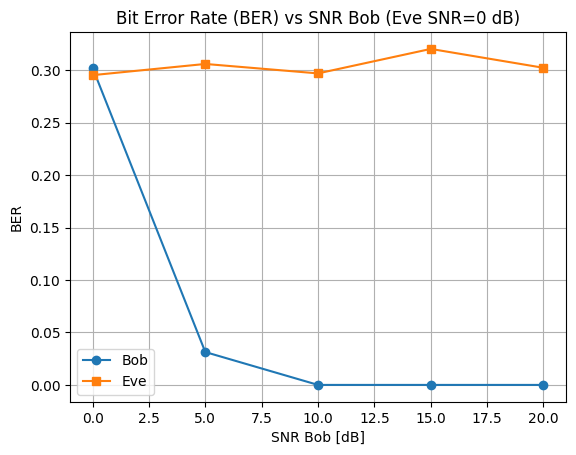

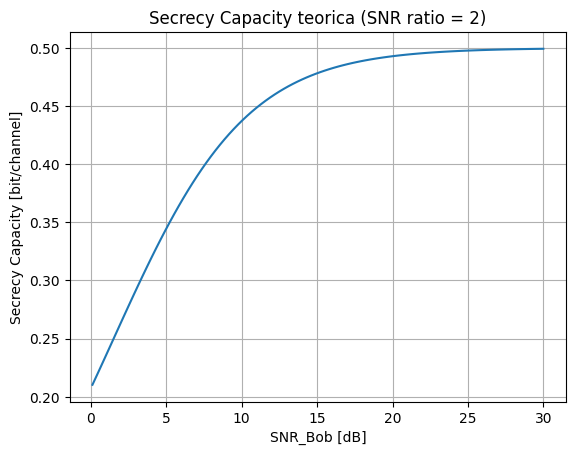

In [147]:
plot_ber_vs_snr(fixed_eve_snr=0)
plot_secrecy_capacity()